In [76]:
# -*- coding: utf-8 -*-
import os
import random

import numpy as np
import matplotlib.pyplot as plt

from scipy.optimize import minimize
from datetime import datetime
from scipy.special import logsumexp

In [77]:
def set_random_seeds(seed_value):

    np.random.seed(seed_value)
    random.seed(seed_value)

set_random_seeds(0)

In [78]:
class Obstacle:
    def __init__(self, obstacle_positions, obstacle_radius, boundary_x, boundary_y, obs_cost):
        self.obstacle_positions = np.array(obstacle_positions)
        self.obstacle_radius = np.array(obstacle_radius)
        self.obs_cost = obs_cost
        self.boundary_x = boundary_x
        self.boundary_y = boundary_y

    def compute_obstacle_cost(self, x_curr):
        num_obs = len(self.obstacle_positions)
        cost = 0
        for obs_i in range(num_obs):
            op = self.obstacle_positions[obs_i]
            cost += float(x_curr[0] > op[0] and x_curr[0] < op[0] + self.obstacle_radius[obs_i] and
                          x_curr[1] > op[1] and x_curr[1] < op[1] + self.obstacle_radius[obs_i]) * self.obs_cost
        return cost

    def compute_boundary_penalty(self, x_curr):
        return float(x_curr[0] < self.boundary_x[0] or x_curr[0] > self.boundary_x[1] or
                     x_curr[1] < self.boundary_y[0] or x_curr[1] > self.boundary_y[1]) * self.obs_cost

    def check_hit_obstacle(self, x_curr):
        for pos, r in zip(self.obstacle_positions, self.obstacle_radius):
            if (x_curr[0] > pos[0] and x_curr[0] < pos[0] + r and x_curr[1] > pos[1] and x_curr[1] < pos[1] + r):
                return True
        return False

    def check_hit_boundary(self, x_curr):
        return x_curr[0] < self.boundary_x[0] or x_curr[0] > self.boundary_x[1] or x_curr[1] < self.boundary_y[0] or x_curr[1] > self.boundary_y[1]

    def plot_obstacles(self, ax):
        for obs_pos, obs_r in zip(self.obstacle_positions, self.obstacle_radius):
            obs = plt.Rectangle(obs_pos, obs_r, obs_r, color='k', fill=True, zorder=6)
            ax.add_patch(obs)

In [79]:
class Dynamics:
    def __init__(self, F, G, S):
        self.F = F
        self.G = G
        self.S = S

    def compute_next_state(self, x_curr, u_curr, noise):
        return self.F @ x_curr + self.G @ u_curr + self.S @ noise

In [80]:
class PathIntegral:
    def __init__(self, dynamics, obstacle, true_mu, Sigma, x_init, x_goal, dist_weight, T, dt, num_trajs, max_steps, num_simulation, gammas, method):
        self.dynamics = dynamics
        self.obstacle = obstacle
        self.x_init = x_init
        self.x_goal = x_goal
        self.num_simulation = num_simulation
        self.dist_weight = dist_weight
        self.T = T
        self.dt = dt
        self.num_trajs = num_trajs
        self.gammas = gammas
        self.method = method
        self.time_steps = int(self.T/self.dt)
        self.max_steps = max_steps

        self.true_mu = true_mu
        self.Sigma = Sigma

        self.goal_tolerance = 0.1
        #self.goal_tolerance_sq = self.goal_tolerance ** 2
        self.dist_to_goal = 1e9
        
        self.state_dim = len(self.x_init)
    
        self.success_time = []
        self.success_index = []
        self.fail_index = []

        self.x_hists = np.zeros((num_simulation, max_steps+1, 2))*np.nan

    def path_integral(self):
        noise_samples = self.sample_noise()
        costs = self.rollout(noise_samples)

        if self.method == 'DR Non':
            u_curr = self.update_useq_risk_neutral(costs, noise_samples, lambda_neut=100)
        elif self.method == 'DR NM':
            u_curr = self.update_control_sequence_NM(costs, noise_samples)
        else:
            raise ValueError(f"Unknown method: {self.method}")
            
        return u_curr

    def estimate_mu(self):
        return np.mean(np.random.multivariate_normal(self.true_mu, self.Sigma, self.num_trajs), axis=0)

    def sample_noise(self) :
        estimated_mu = self.estimate_mu()
        noise_samples = np.random.multivariate_normal(estimated_mu, self.Sigma , [self.num_trajs, self.time_steps])
        return noise_samples

    def rollout(self, noise_samples):
        costs = np.zeros(self.num_trajs)
        goal_reached = False
        
        for k in range(self.num_trajs):
            x_curr = self.x_init.copy()
                
            for t in range(self.time_steps):
            
                x_curr = self.dynamics.compute_next_state(x_curr, np.zeros(2), noise_samples[k, t, :])
                    
                dist_to_goal = np.linalg.norm(x_curr[:2] - self.x_goal[:2])
                
                # Calculate Costs
                costs[k] += self.dist_weight * dist_to_goal # stage cost
                if dist_to_goal < 0.01 :
                    break
        
                costs[k] += self.obstacle.compute_obstacle_cost(x_curr) # obstacle cost
                    
                costs[k] += self.obstacle.compute_boundary_penalty(x_curr) # boundary penalty
                if dist_to_goal <= self.goal_tolerance:
                    goal_reached = True
                    break
                
                costs[k] += (1 - float(goal_reached)) * dist_to_goal # terminal cost

        return costs

    def calculate_new_control_sequence(self, costs, lambda_, noise_samples):
        costs = np.exp(-costs / lambda_)
        sum_costs = np.sum(costs)

        time_steps, n = noise_samples.shape[1:3]
        u_curr = np.zeros((time_steps, n))
        for k in range(len(costs)):
            u_curr[0, :] += (costs[k] / sum_costs) * noise_samples[k, 0, :]
        
        return u_curr
    
    def update_useq_risk_neutral(self, costs, noise_samples,lambda_neut=100) :
        return self.calculate_new_control_sequence(costs, lambda_neut, noise_samples)

    def update_control_sequence_NM(self, costs, noise_samples):
        # Define the cost function wrapper
        def opt_cost_func(lambda_, gamma, costs, num_trajs):
            log_denominator = logsumexp(-costs / lambda_) - np.log(num_trajs)
            denominator = np.exp(log_denominator)
            if denominator == 0:
                return np.inf  # Return a large value to indicate failure
            return gamma / lambda_ - lambda_ * np.log(denominator)

        for gamma in self.gammas:
            # Alternatively, use the Nelder-Mead method.  'Powell', 'CG', 'BFGS', 'Newton-CG', 'L-BFGS-B', 'TNC', 'COBYLA', 'SLSQP', 'trust-constr', 'dogleg', 'trust-ncg', 'trust-exact', 'trust-krylov'
            result = minimize(opt_cost_func, x0=1.0, args=(gamma, costs, self.num_trajs), method='Powell', options={'maxiter': 10000})

            if result.success:
                lambda_r = result.x[0]
            else:
                print("Optimization failed for gamma =", gamma)
                continue  # Move on to the next gamma if optimization failed

            return self.calculate_new_control_sequence(costs, lambda_r, noise_samples)

    def simulation(self):
        for k in range(self.num_simulation):
            terminate = False
            hit_obstacle = False
            hit_boundary = False

            u_curr = np.zeros((self.time_steps, 2))
            x_hist = np.zeros((self.max_steps+1, 4)) * np.nan
            u_hist = np.zeros((self.max_steps+1, 2)) * np.nan
            x_hist[0] = self.x_init.copy()

            for t in range(self.max_steps):
                
                u_curr = self.path_integral() 
                u_hist[t] = u_curr[0]

                noise = self.true_mu + np.random.multivariate_normal(np.zeros(u_curr.shape[1]), self.Sigma) # drift term + increment of a standard Wiener process
   
                x_hist[t+1] = self.dynamics.compute_next_state(x_hist[t], u_curr[0], noise)

                hit_obstacle = self.obstacle.check_hit_obstacle(x_hist[t+1])
                if hit_obstacle:
                    terminate = True
                    self.fail_index.append(k)
                    print("Hit obstacle")
                    break
                
                hit_boundary = self.obstacle.check_hit_boundary(x_hist[t+1])
                if hit_boundary:
                    terminate = True
                    self.fail_index.append(k)
                    print("Hit boundary")
                    break
                
                # Goal check
                if np.linalg.norm(x_hist[t+1, :2] - self.x_goal) <= self.goal_tolerance:
                    print(f"Goal reached at t={t * self.dt}s")
                    self.success_time.append(t * self.dt)
                    terminate = True
                    self.success_index.append(k)
                    break
            
            self.x_hists[k, :t, :] = x_hist[:t, :2]

            if terminate:
                self.simulation_plot(x_hist)

    def simulation_plot(self, x_hist):
        fig, ax = plt.subplots()
        ax.plot([self.x_init[0]], [self.x_init[1]], '8', markersize=20, markerfacecolor='lime', label='Initial State', markeredgecolor='k', zorder=6)
        ax.plot([self.x_goal[0]], [self.x_goal[1]], '*', markersize=20, markerfacecolor='lime', label='Target State', markeredgecolor='k', zorder=6)
        self.obstacle.plot_obstacles(ax)
        ax.plot(x_hist[:,0], x_hist[:,1], 'r', label='Past state')
        ax.set_xlim(self.obstacle.boundary_x)
        ax.set_ylim(self.obstacle.boundary_y)
        ax.set_xlabel(r'$p_{x}$')
        ax.set_ylabel(r'$p_{y}$')
        plt.gcf().set_dpi(600)
        ax.set_aspect('equal')
        plt.tight_layout()
        plt.show()
            
    def final_result(self):
        fig, ax = plt.subplots()
        ax.plot([self.x_init[0]], [self.x_init[1]], '8', markersize=20, markerfacecolor='lime', label='Initial State', markeredgecolor='k', zorder=6)
        ax.plot([self.x_goal[0]], [self.x_goal[1]], '*', markersize=20, markerfacecolor='lime', label='Target State', markeredgecolor='k', zorder=6)
        self.obstacle.plot_obstacles(ax)

        ax.set_xlim(self.obstacle.boundary_x)
        ax.set_ylim(self.obstacle.boundary_y)
        ax.set_xlabel(r'$p_{x}$')
        ax.set_ylabel(r'$p_{y}$')
        plt.gcf().set_dpi(600)
        ax.set_aspect('equal')
        plt.tight_layout()

        ax.plot(self.x_hists[self.success_index,:,0].T, self.x_hists[self.success_index,:,1].T, 'b', linewidth=0.8)
        ax.plot(self.x_hists[self.fail_index,:,0].T, self.x_hists[self.fail_index,:,1].T, 'r', linewidth=0.8)
        ax.set_title(f'Trajectories using {self.method} method')

        # Save the plot with the current time as the filename
        filename = os.path.join("./log", f"plot_{datetime.now().strftime('%Y-%m-%d_%H-%M-%S')}.png")
        os.makedirs(os.path.dirname(filename), exist_ok=True)
        fig.savefig(filename)

        plt.show()

In [81]:
method = 'DR Non' # method = 'DR Non', 'DR bisection', 'DR grid_search', 'DR NM'

T = 10.0
dt = 0.1

In [82]:
obstacle_positions = np.array([[-2.5, 0.0]])
obstacle_radius = np.array([2.0])

obs_cost = 1e3

boundary_x = [-4.0, 1.0]
boundary_y = [-1.0, 4.0]

obstacle = Obstacle(obstacle_positions, obstacle_radius, boundary_x, boundary_y, obs_cost)

In [83]:
F = np.array([[1, 0, dt, 0],
              [0, 1, 0, dt],
              [0, 0, 1, 0],
              [0, 0, 0, 1]])
        
G= np.array([[(dt**2)/2, 0],
             [0, (dt**2)/2],
             [dt, 0],
             [0, dt]])

dynamics = Dynamics(F, G, G)

In [84]:
num_simulation = 10
max_steps = 600
num_trajs = 30

true_mu = np.array([0.003, 0.003])
Sigma = np.array([[0.01, 0.0], 
                  [0.0, 0.01]])

dist_weight = 0.01

gamma = [300]

goal_tolerance = 0.1

x_init = np.array([-3.0, 3.0, 0, 0])
x_goal = np.array([0,0])

path_integral = PathIntegral(dynamics, obstacle, true_mu, Sigma, x_init, x_goal, dist_weight, T, dt, num_trajs, max_steps, num_simulation, gamma, method)

Hit obstacle


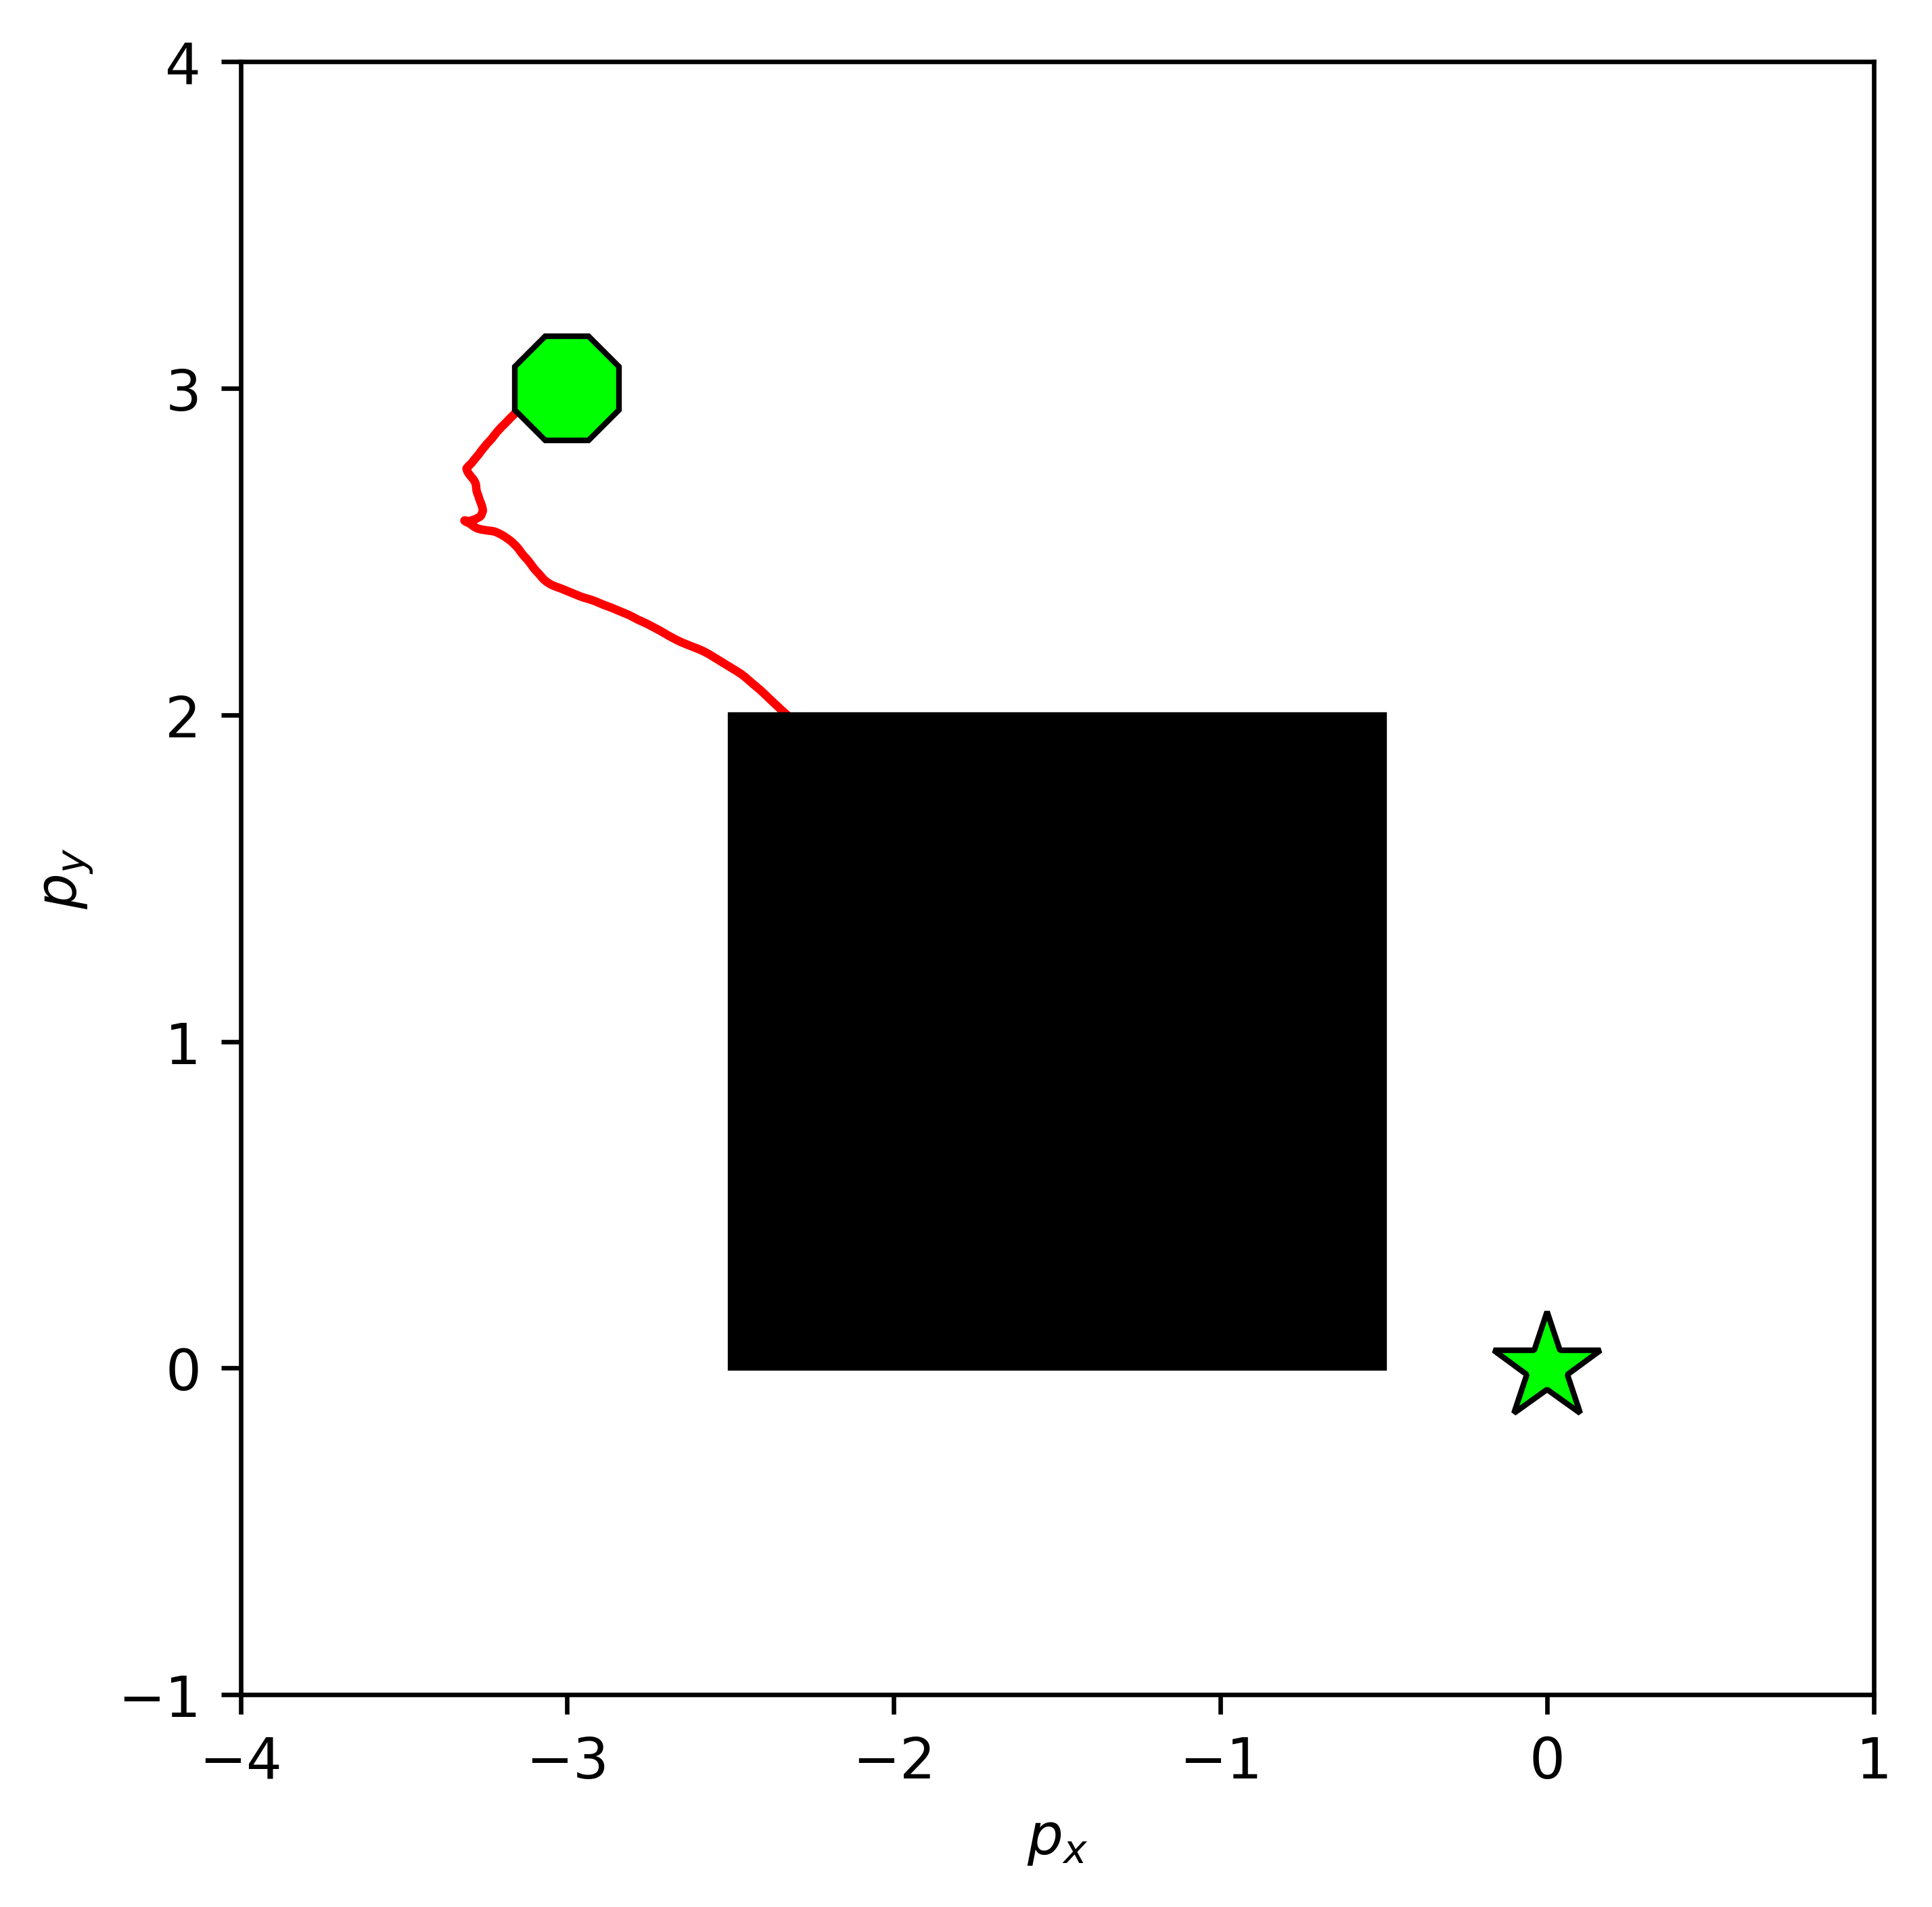

Hit boundary


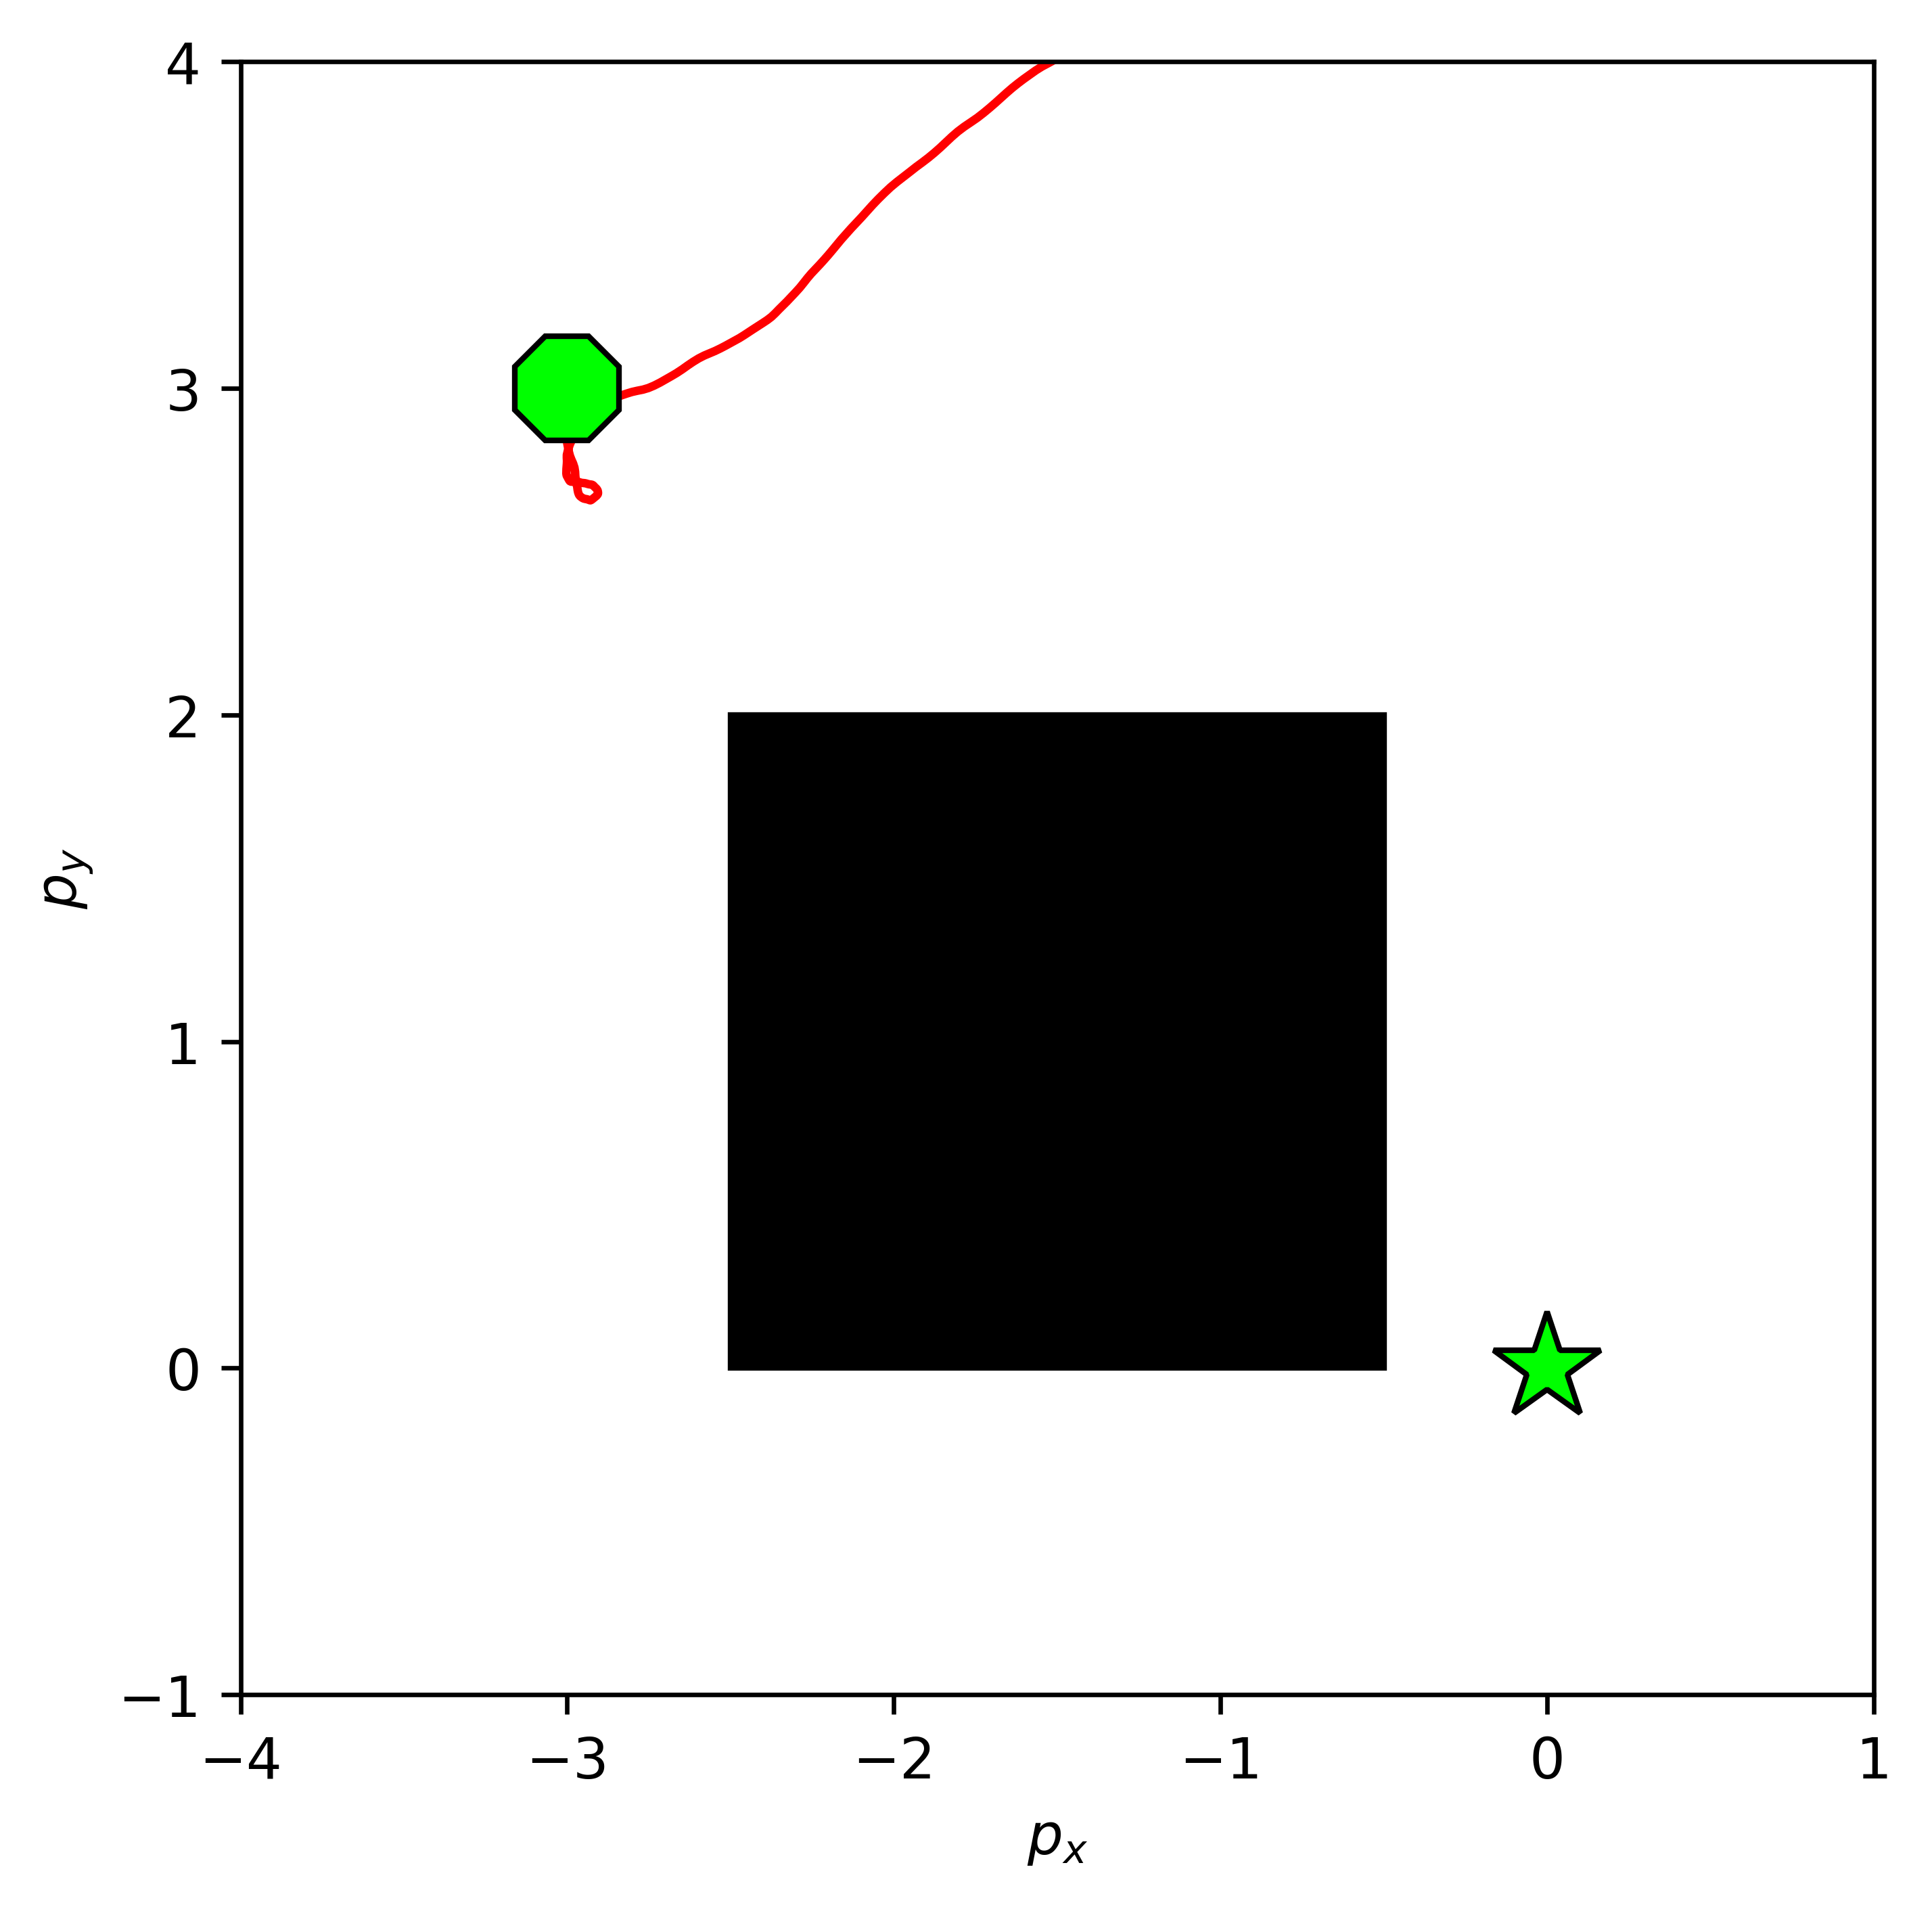

Hit boundary


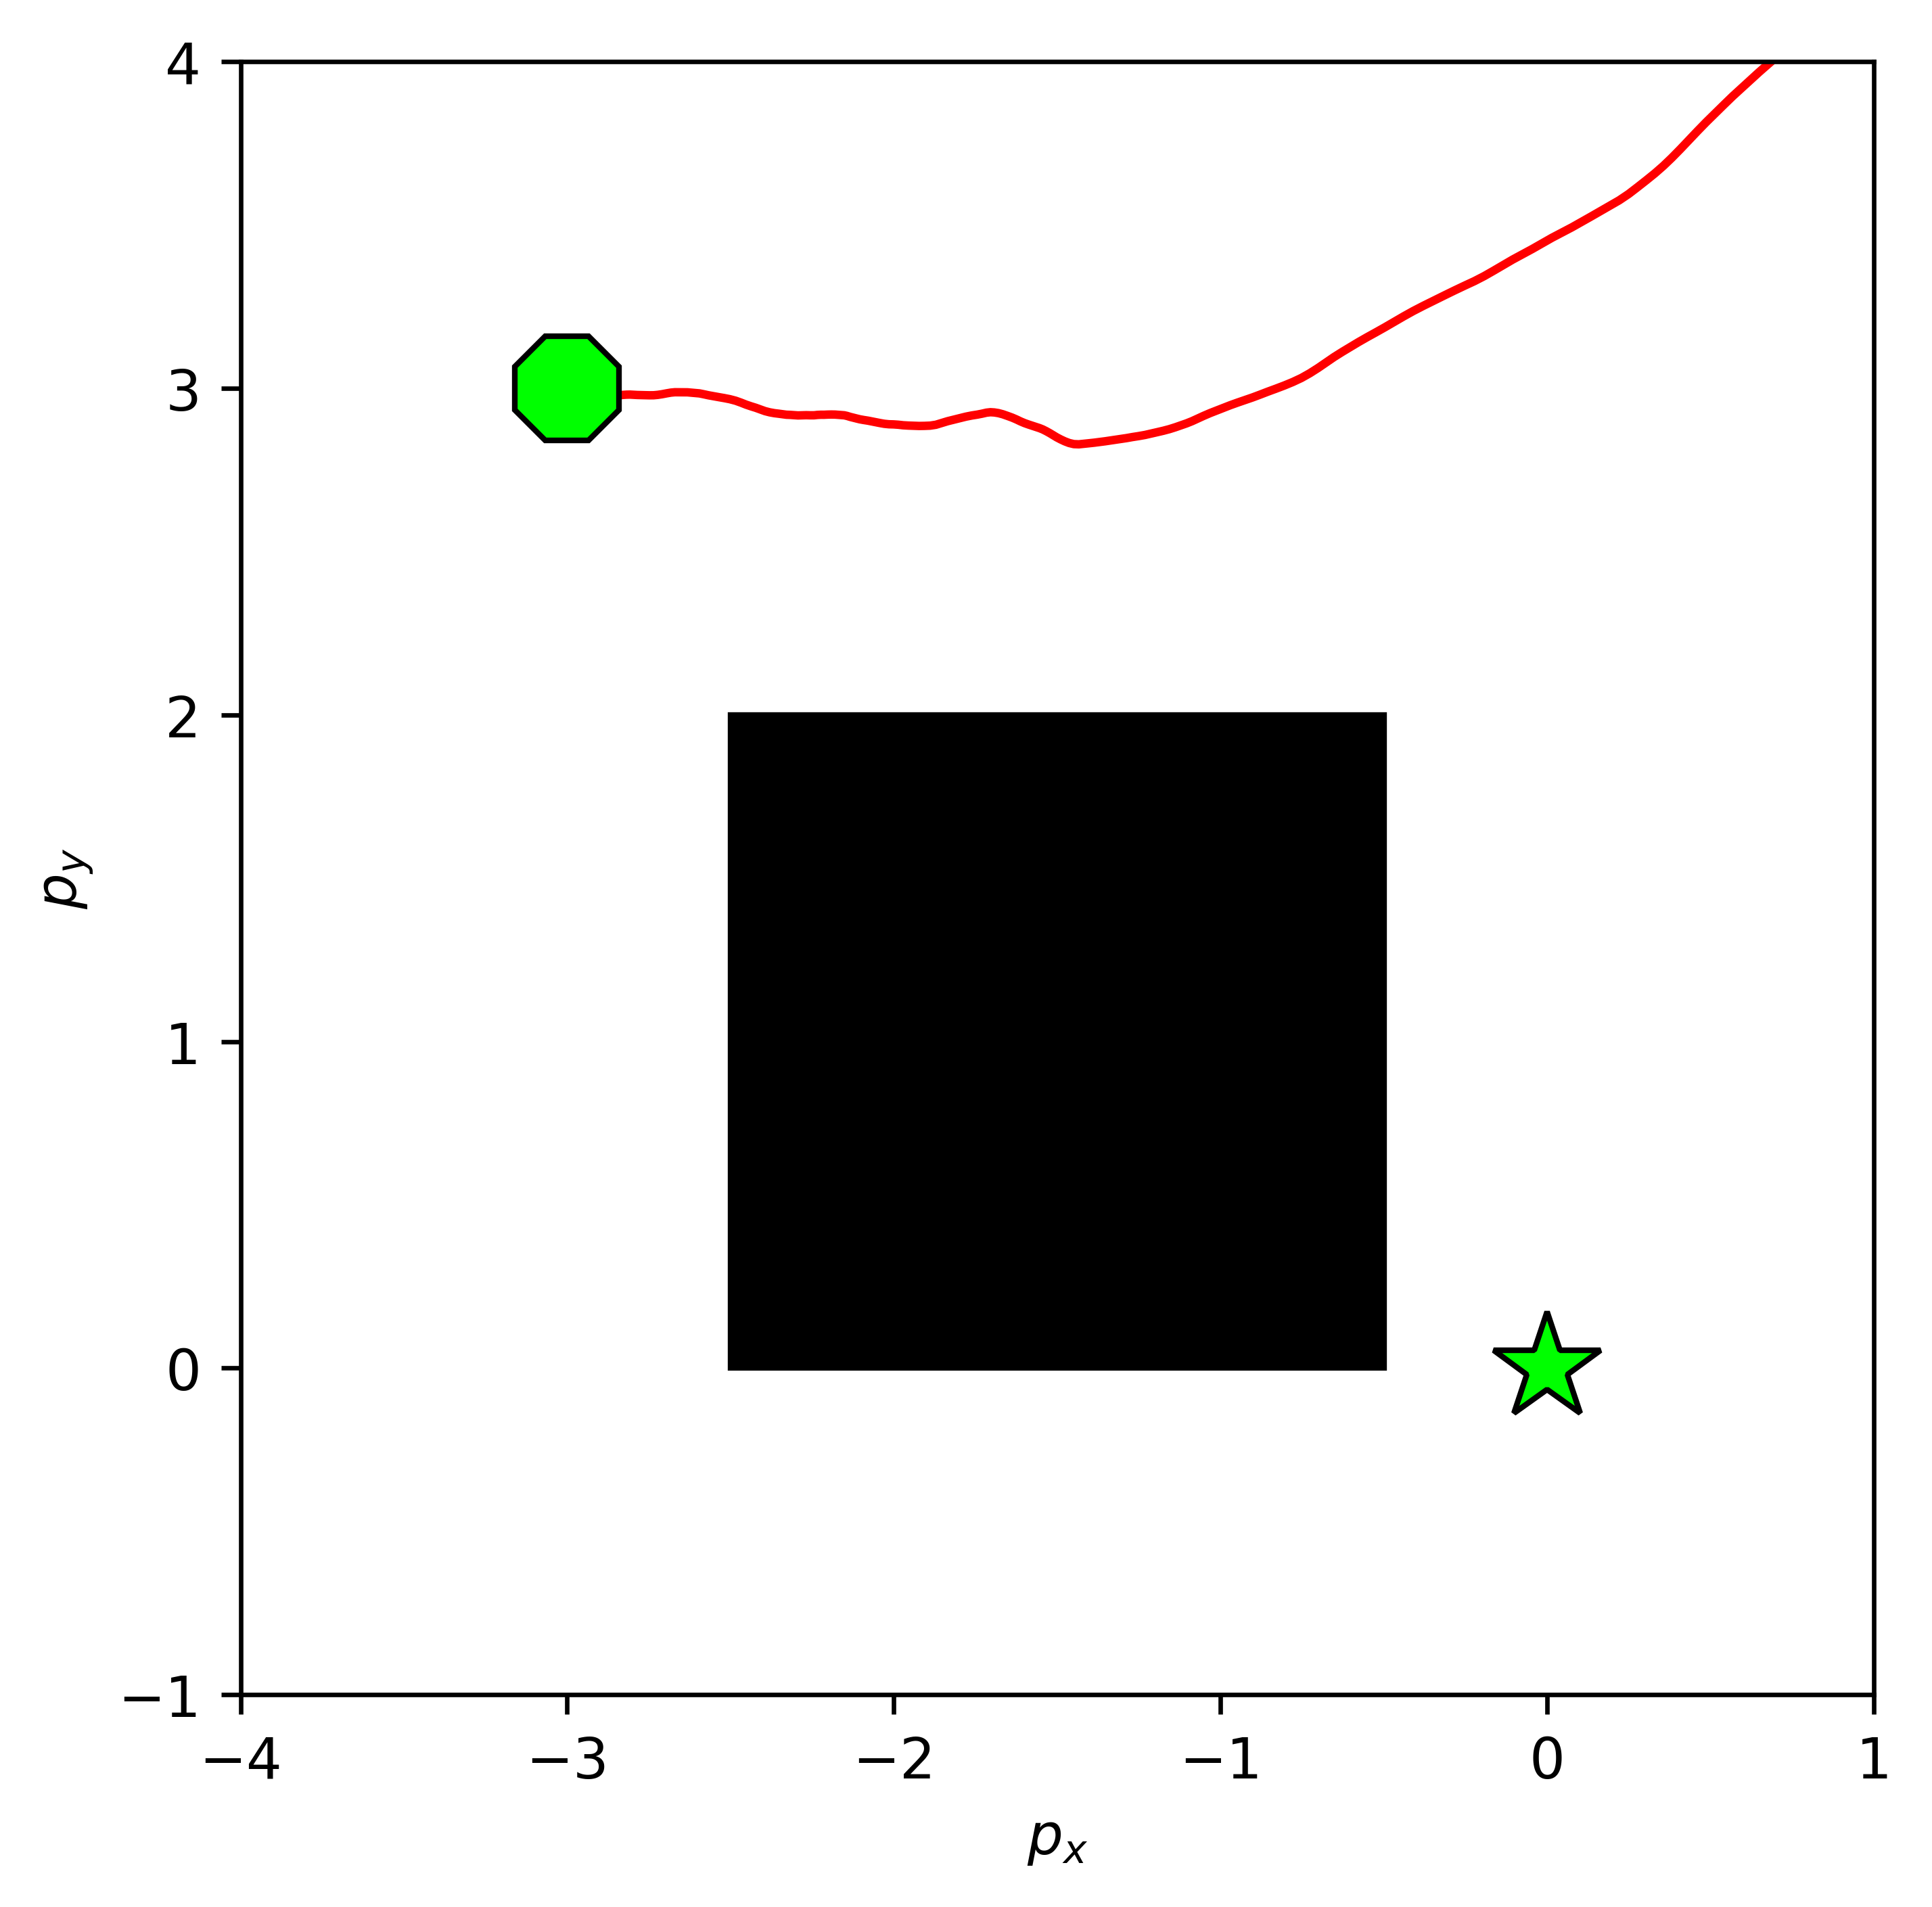

KeyboardInterrupt: 

In [85]:
path_integral.simulation()